In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium import FeatureGroup
from config import vworld_key
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from shapely import wkt
import rasterio
import base64
from matplotlib import pyplot
from rasterio.plot import show
import matplotlib.pyplot as plt

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

## xml 정보 위성사진에 매핑하기

In [34]:
tif_df = {
    'file_name':[],
    'file_path':[],
    'time':[],
    'imagegeogcenter':[],
    'imagegeogtl':[],
    'imagegeogtc':[],
    'imagegeogtr':[],
    'imagegeogbl':[],
    'imagegeogbc':[],
    'imagegeogbr':[],
}

# 상위 디렉토리 경로 설정
base_directory = "dataset/20.국토지리정보원_위성영상(RGB_NIR)"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
for directory in subdirectories:
    # 디렉토리 내의 XML 파일 목록 가져오기
    xml_files = [f for f in os.listdir(directory) if f.endswith("Aux.xml")]

    # 각 XML 파일을 읽어서 처리
    for xml_file in xml_files:
        xml_file_path = os.path.join(directory, xml_file)
                
        with open(xml_file_path, 'r', encoding='utf-8') as f:
            xml_doc = f.read()
        soup = bs(xml_doc, 'lxml')
        # TIFF이미지 형식 1번부터 4번까지 순회(BGRN 순)
        for img_no in range(4,5):

            # soup로 이미지 번호에 해당하는 객체 탐색
            img_lxml = soup.find("MS%s"%img_no) if soup.find("MS%s"%img_no) else soup.find("ms%s"%img_no)
            

            # 이미지 파일이름 추출 및 저장
            tif_df['file_name'].append(img_lxml.find('imagefilename').text)

            # 이미지 파일경로 저장

            tif_df['file_path'].append(directory + '/' + img_lxml.find('imagefilename').text.replace(".tif", "_geotiff.tif"))

            # UTC to yy-mm-dd 변환 및 저장
            text = img_lxml.find('utc').text.split('.')[0]
            datetime_obj = datetime.strptime(text, "%Y%m%d%H%M%S")
            tif_df['time'].append(datetime_obj.strftime("%y-%m-%d"))

            # 이미지 위치정보 저장
            img_point = ['imagegeogcenter', 'imagegeogtl', 'imagegeogtc', 'imagegeogtr', 'imagegeogbl', 'imagegeogbc', 'imagegeogbr'] # 딕셔너리 3~9 column
            lat_lst = img_lxml.find_all('latitude')
            lon_lst = img_lxml.find_all('longitude')
            for point, lat, lon in zip(img_point, lat_lst, lon_lst):
                tif_df[point].append(Point(lon, lat))

xml_metadata_df = pd.DataFrame(tif_df)
xml_metadata_df

,file_name,file_path,time,imagegeogcenter,imagegeogtl,imagegeogtc,imagegeogtr,imagegeogbl,imagegeogbc,imagegeogbr
0,C1_20230624015314_12527_00071291_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023062401...,23-06-24,POINT (126.709245 37.267593),POINT (126.615293 37.334427),POINT (126.708538 37.335088),POINT (126.801798 37.335675),POINT (126.616871 37.199436),POINT (126.70995 37.200093),POINT (126.803044 37.200678)
1,C1_20230624015314_12527_00093015_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023062401...,23-06-24,POINT (126.678512 37.370226),POINT (126.584346 37.437072),POINT (126.677775 37.437759),POINT (126.771212 37.438372),POINT (126.585986 37.302003),POINT (126.679248 37.302687),POINT (126.772517 37.303297)
2,C1_20230719015507_12907_00322813_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023071901...,23-07-19,POINT (126.869954 37.264529),POINT (126.782672 37.330089),POINT (126.869403 37.330583),POINT (126.956147 37.331014),POINT (126.783924 37.197977),POINT (126.870504 37.198468),POINT (126.957097 37.198897)
3,C1_20230808015601_13211_00650427_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023080801...,23-08-08,POINT (126.92474 37.42322),POINT (126.839744 37.488296),POINT (126.924238 37.488738),POINT (127.008745 37.489119),POINT (126.840894 37.357257),POINT (126.925241 37.357697),POINT (127.0096 37.358077)
4,C1_20230907015813_13667_00052295_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023090701...,23-09-07,POINT (126.939949 37.356858),POINT (126.856797 37.421518),POINT (126.939465 37.421939),POINT (127.022145 37.422302),POINT (126.857907 37.291348),POINT (126.940432 37.291767),POINT (127.02297 37.292128)
5,C1_20230908013931_13682_00057979_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023090801...,23-09-08,POINT (126.786612 37.349092),POINT (126.640978 37.427096),POINT (126.785864 37.42806),POINT (126.930761 37.428847),POINT (126.642776 37.269154),POINT (126.787358 37.270113),POINT (126.931952 37.270895)


In [ ]:
import folium
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from folium import plugins
from matplotlib.colors import ListedColormap

# Folium 맵 생성
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=10)  # 지도의 중심 좌표와 줌 레벨 설정

# for _, row in xml_metadata_df.iterrows() :
#     # GeoTIFF 파일 경로 설정
#     geotiff_file_path = row['file_path']  # GeoTIFF 파일의 경로
#     # GeoTIFF 파일 열기
#     src = rasterio.open(geotiff_file_path)
#     array = src.read(1)

#     # Shapely Point 객체로 top-left 좌표를 파싱
#     tl_point = wkt.loads(str(row['imagegeogtl']))

#     # Shapely Point 객체로 bottom right 좌표를 파싱
#     br_point = wkt.loads(str(row['imagegeogbr']))

# with rasterio.open('dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/LC08_L1TP_116034_20210618_20210628_02_T1_B11.TIF') as thermal_src:
#     s_band = thermal_src.read(1)

# 배열을 이미지로 변환 (예: 0-1 범위로 정규화한 후 색상 맵을 적용)
#normalized_data = (average_temperature - average_temperature.min()) / (average_temperature.max() - average_temperature.min())

# Colormap 설정

# 일반 PNG 이미지를 Folium에 추가
folium.raster_layers.ImageOverlay(
    image=average_temperature,
    bounds=[[38.51209, 125.25103], [38.56742, 127.94740], [36.41261, 127.97722], [36.36139, 125.35696]],
    opacity=0.9,
    interactive=True,
).add_to(m)

# Folium 지도를 출력
m

In [ ]:
import folium
from folium.vector_layers import Polygon

# Folium 지도 생성
m = folium.Map(location=[37.46209, 126.92103], zoom_start=10)

# 4개의 좌표 설정
coordinates = [[38.51209, 125.25103], [38.56742, 127.94740], [36.41261, 127.97722], [36.36139, 125.35696]]

# 폴리곤 생성
polygon = Polygon(locations=coordinates, color='blue', fill_color='blue', fill_opacity=0.4)

# 폴리곤을 맵에 추가
polygon.add_to(m)

# 맵을 표시
m


### 영상 DN(Digidal Number) 값을 대기상부 복사휘도TOA Radiance(대기상부 복사휘도)로 변환

TOA 분광 복사휘도(TOA spectral radiance) = 

밴드 고유의 배수 환산계수(Band-specific multiplicative rescaling factor) * DN 값 + 밴드 고유의 가산 환산계수(Band-specific additive rescaling factor)

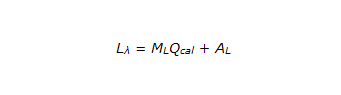

배수 환산계수와 가산 환산계수는 각각 RADIANCE_MULT_BAND_x, RADIANCE_ADD_BAND_x형식으로 메타데이터 내에 정의되어 있음

In [26]:
# tif_df = {
#     'file_name':[],
#     'file_path':[],
#     'time':[],
#     'imagegeogcenter':[],
#     'imagegeogtl':[],
#     'imagegeogtc':[],
#     'imagegeogtr':[],
#     'imagegeogbl':[],
#     'imagegeogbc':[],
#     'imagegeogbr':[],
# }

lst = []

# 상위 디렉토리 경로 설정
base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
for directory in subdirectories:
    # 디렉토리 내의 Metadata XML 파일 탐색 (폴더 당 1개씩만 있기 때문에 인덱스 0으로 로드)
    xml_file = [f for f in os.listdir(directory) if f.endswith("MTL.xml")][0]

    # XML파일 path정의
    xml_file_path = os.path.join(directory, xml_file) 
    # XML파일 읽기
    with open(xml_file_path, 'r', encoding='utf-8') as f:
        xml_doc = f.read()
    # beautifulsoup으로 xml parsing 
    soup = bs(xml_doc, 'lxml')
    lst.append(soup)
    # TIFF이미지 형식 1번부터 4번까지 순회(BGRN 순)
    # for img_no in range(4,5):

    #     # soup로 이미지 번호에 해당하는 객체 탐색
    #     img_lxml = soup.find("MS%s"%img_no) if soup.find("MS%s"%img_no) else soup.find("ms%s"%img_no)
    

    #     # 이미지 파일이름 추출 및 저장
    #     tif_df['file_name'].append(img_lxml.find('imagefilename').text)

    #     # 이미지 파일경로 저장

    #     tif_df['file_path'].append(directory + '/' + img_lxml.find('imagefilename').text.replace(".tif", "_geotiff.tif"))

    #     # UTC to yy-mm-dd 변환 및 저장
    #     text = img_lxml.find('utc').text.split('.')[0]
    #     datetime_obj = datetime.strptime(text, "%Y%m%d%H%M%S")
    #     tif_df['time'].append(datetime_obj.strftime("%y-%m-%d"))

    #     # 이미지 위치정보 저장
    #     img_point = ['imagegeogcenter', 'imagegeogtl', 'imagegeogtc', 'imagegeogtr', 'imagegeogbl', 'imagegeogbc', 'imagegeogbr'] # 딕셔너리 3~9 column
    #     lat_lst = img_lxml.find_all('latitude')
    #     lon_lst = img_lxml.find_all('longitude')
    #     for point, lat, lon in zip(img_point, lat_lst, lon_lst):
    #         tif_df[point].append(Point(lon, lat))

# xml_metadata_df = pd.DataFrame(tif_df)
# xml_metadata_df

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [32]:
lst[0].find("file_name_band_10")

<file_name_band_10>LC08_L1TP_116034_20210618_20210628_02_T1_B10.TIF</file_name_band_10>

In [33]:
lst[0]

<?xml version="1.0" encoding="UTF-8"?><html><body><landsat_metadata_file>
<product_contents>
<origin>Image courtesy of the U.S. Geological Survey</origin>
<digital_object_identifier>https://doi.org/10.5066/P975CC9B</digital_object_identifier>
<landsat_product_id>LC08_L1TP_116034_20210618_20210628_02_T1</landsat_product_id>
<processing_level>L1TP</processing_level>
<collection_number>02</collection_number>
<collection_category>T1</collection_category>
<output_format>GEOTIFF</output_format>
<file_name_band_1>LC08_L1TP_116034_20210618_20210628_02_T1_B1.TIF</file_name_band_1>
<file_name_band_2>LC08_L1TP_116034_20210618_20210628_02_T1_B2.TIF</file_name_band_2>
<file_name_band_3>LC08_L1TP_116034_20210618_20210628_02_T1_B3.TIF</file_name_band_3>
<file_name_band_4>LC08_L1TP_116034_20210618_20210628_02_T1_B4.TIF</file_name_band_4>
<file_name_band_5>LC08_L1TP_116034_20210618_20210628_02_T1_B5.TIF</file_name_band_5>
<file_name_band_6>LC08_L1TP_116034_20210618_20210628_02_T1_B6.TIF</file_name_band

In [14]:
import numpy as np

# 주어진 메타데이터 및 데이터
RADIANCE_MAXIMUM = 22.00180  # 예시 값을 사용하였습니다. 실제 데이터에 맞게 설정하세요.
RADIANCE_MINIMUM = 0.10033
RADIANCE_MULT = 3.3420E-04
RADIANCE_ADD = 0.10000
K1_THERMAL_CONSTANT = 774.8853  # 예시 값을 사용하였습니다. 실제 값으로 변경하세요.
K2_THERMAL_CONSTANT = 1321.0789  # 예시 값을 사용하였습니다. 실제 값으로 변경하세요.
satellite_data = band10_data  # 예시 데이터를 사용하였습니다.

# 발광값 계산
radiance = (satellite_data * RADIANCE_MULT) + RADIANCE_ADD
radiance = np.maximum(radiance, RADIANCE_MINIMUM)
radiance = np.minimum(radiance, RADIANCE_MAXIMUM)

# Planck's Law를 사용하여 열온도 계산
temperature = K2_THERMAL_CONSTANT / np.log((K1_THERMAL_CONSTANT / radiance) + 1)

print("계산된 열온도:")
print(temperature)


계산된 열온도:
[[251.39591117 251.37244544 251.3450596  ... 274.9707322  275.11879284
  275.29911649]
 [251.37244544 251.37244544 251.35288514 ... 274.8966156  274.98554861
  275.13062778]
 [251.36853379 251.38026816 251.34897247 ... 274.86398602 274.88475159
  274.97665904]
 ...
 [260.1715827  261.13566071 262.02029281 ... 278.14796174 278.18810252
  278.20530069]
 [259.76450155 260.75067318 261.63591737 ... 278.33132873 278.37139472
  278.37997816]
 [259.67298325 260.55576818 261.31885968 ... 278.48863708 278.53435236
  278.53720886]]


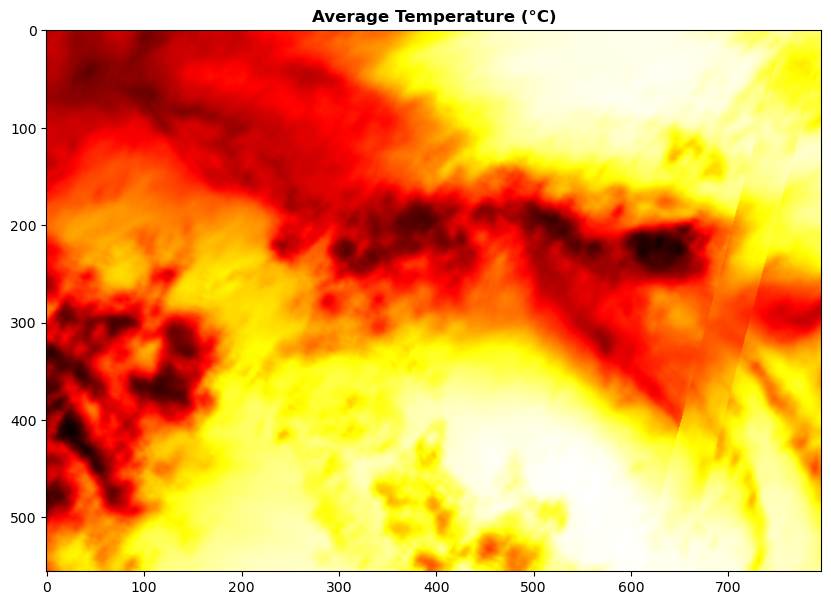

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Landsat 8 데이터 파일 경로 및 파일명 설정
# 예를 들어, BAND10 및 BAND11에 해당하는 파일 경로를 설정합니다.
band10_file = "dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/LC08_L1TP_116034_20210618_20210628_02_T1_B10.TIF"
band11_file = "dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/LC08_L1TP_116034_20210618_20210628_02_T1_B11.TIF"

# 파일 열기
with rasterio.open(band10_file) as band10_ds, rasterio.open(band11_file) as band11_ds:
    # Band10과 Band11 데이터 읽어오기
    band10_data = band10_ds.read(1)
    band11_data = band11_ds.read(1)

    # Band10 및 Band11에 대한 Planck 방정식 상수 설정 (K1 및 K2)
    k1_band10 = 774.8853
    k2_band10 = 1321.0789
    k1_band11 = 480.8883
    k2_band11 = 1201.1442

    # Planck 방정식을 사용하여 열온도 계산 (Band10 및 Band11 각각)
    temperature_band10 = k2_band10 / np.log((k1_band10 / band10_data + 1) + k2_band10)
    temperature_band11 = k2_band11 / np.log((k1_band11 / band11_data + 1) + k2_band11)

    # 두 개의 열온도 밴드를 결합하여 평균 열온도 계산
    average_temperature = (temperature_band10 + temperature_band11) / 2

    # 시각화
    plt.figure(figsize=(10, 10))
    plt.title("지표면 온도 분포 지도")
    show(average_temperature, cmap='hot', title="Average Temperature (°C)")
    plt.show()

In [4]:
average_temperature

array([[176.59169562, 176.59169494, 176.59169428, ..., 176.59205818,
        176.59205787, 176.59205751],
       [176.59169484, 176.59169468, 176.59169419, ..., 176.59205727,
        176.59205685, 176.59205633],
       [176.59169427, 176.5916944 , 176.59169381, ..., 176.59205546,
        176.59205463, 176.59205391],
       ...,
       [176.59183103, 176.59183712, 176.59184441, ..., 176.5920882 ,
        176.59208795, 176.59208727],
       [176.59182887, 176.59183503, 176.59184088, ..., 176.59209031,
        176.59209016, 176.59208934],
       [176.59183069, 176.59183529, 176.59183919, ..., 176.59209221,
        176.59209207, 176.59209121]])

In [158]:
import rasterio

# Landsat 8 데이터 파일 경로 및 파일명 설정 (BAND10 또는 BAND11에 해당하는 파일)
band_file = "dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/LC08_L1TP_116034_20210618_20210628_02_T1_B10.TIF"  # 또는 "path_to_band11.tif"

# 특정 픽셀의 좌표 (행, 열) 설정
pixel_row = 256  # 원하는 픽셀의 행 번호
pixel_col = 390  # 원하는 픽셀의 열 번호

# 파일 열기
with rasterio.open(band_file) as dataset:
    # Band 데이터 읽어오기
    band_data = dataset.read(1)

    # Band에 대한 Planck 방정식 상수 설정 (K1 및 K2)
    k1_constant = 774.8853
    k2_constant = 1321.0789

    # 특정 픽셀에서의 방사량 값 추출
    pixel_radiance = band_data[pixel_row, pixel_col]

    # Planck 방정식을 사용하여 온도 계산
    pixel_temperature = k2_constant / np.log((k1_constant / pixel_radiance + 1) + k2_constant)
    print(f"특정 픽셀에서의 온도: {pixel_temperature} °C")


특정 픽셀에서의 온도: 183.81490562876536 °C


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 상위 디렉토리 경로 설정
base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
#for directory in subdirectories:
    # 입력 폴더에서 모든 TIF 파일 찾기
directory = subdirectories[0]
tif_files = glob.glob(os.path.join(directory + '/', "*.tif"))


# 단계 1: 데이터 불러오기
# Landsat 8 데이터 경로 설정
thermal_band_paths = tif_files[:11]
saa_band_path = tif_files[-4]  # SAA (Solar Azimuth Angle) 밴드 경로
sza_band_path = tif_files[-3]  # SZA (Solar Zenith Angle) 밴드 경로
vaa_band_path = tif_files[-2]  # VAA (Viewing Azimuth Angle) 밴드 경로
vza_band_path = tif_files[-1]  # VZA (Viewing Zenith Angle) 밴드 경로
qa_pixel_band_path = tif_files[11]  # Pixel Quality Assessment Band (QA_Pixel) 밴드 경로
qa_radsat_band_path = tif_files[12]  # Radiometric Saturation Quality Assessment Band (QA_RADSAT) 밴드 경로

# 데이터 불러오기
def load_band(path):
    with rasterio.open(path) as src:
        return src.read(1)

thermal_bands = [load_band(path) for path in thermal_band_paths]
saa_band = load_band(saa_band_path)
sza_band = load_band(sza_band_path)
vaa_band = load_band(vaa_band_path)
vza_band = load_band(vza_band_path)
qa_pixel_band = load_band(qa_pixel_band_path)
qa_radsat_band = load_band(qa_radsat_band_path)

#단계 2: 임계값 적용
#QA_Pixel 밴드를 사용하여 데이터 품질을 관리합니다.
#원하는 데이터 품질을 선택합니다.
desired_quality_mask = qa_pixel_band  # 원하는 품질 값을 설정하세요.

# 데이터에 품질 마스크 적용
for i in range(len(thermal_bands)):
    thermal_bands[i] = np.where(desired_quality_mask, thermal_bands[i], np.nan)

# # 단계 3: 라디오미터 표면 반사 밴드 복원 (필요한 경우)
# # 반사 밴드와 계수 변환을 사용하여 표면 반사값을 계산합니다.

# # 반사 밴드 경로 설정
# reflectance_band_paths = ['reflectance_band1.tif', 'reflectance_band2.tif', 'reflectance_band3.tif',
#                           'reflectance_band4.tif', 'reflectance_band5.tif', 'reflectance_band6.tif',
#                           'reflectance_band7.tif']

# # 반사 밴드 불러오기
# reflectance_bands = [load_band(path) for path in reflectance_band_paths]

# # 계수 변환 (반사 밴드에서 계수 추출 또는 제공된 계수 사용)

# # 라디오미터 표면 반사값 계산 (예시)
# surface_reflectance_bands = [reflectance_bands[i] * coefficient for i, coefficient in enumerate(coefficients)]

# # 단계 4: Planck 방정식 사용하여 열온도 계산
# # 계산된 표면 반사값과 라디오미터 계수를 사용하여 열온도를 계산합니다.

# # Planck 방정식 상수
# planck_a = 0.0003342
# planck_b = 0.1

# # 열온도 계산 (11개 밴드 모두 사용)
# def calculate_temperature(bands, saa, sza):
#     radiance_sum = sum([band / (np.exp(planck_a * band / (planck_b * sza)) - 1) for band in bands])
#     temperature = planck_b / np.log(1 + (radiance_sum * (sza ** 2)) / saa)
#     return temperature

# # 열온도 계산
# temperature_map = calculate_temperature(thermal_bands, saa_band, sza_band)

# # 단계 5: 결과 시각화
# # 계산된 열온도 데이터를 사용하여 지표면 온도 분포를 시각화합니다.

# plt.figure(figsize=(10, 10))
# plt.imshow(temperature_map, cmap='hot', vmin=temperature_min, vmax=temperature_max)
# plt.colorbar(label='Surface Temperature (K)')
# plt.title('Surface Temperature Distribution')
# plt.axis('off')
# plt.show()


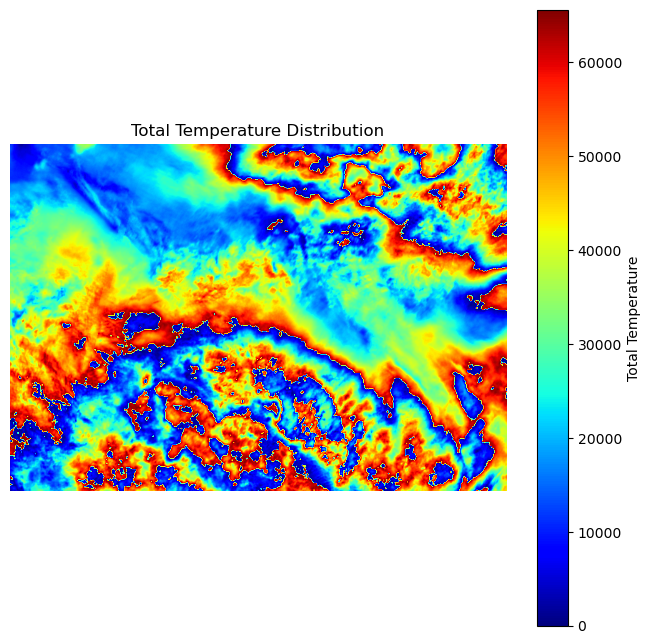

In [108]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
          
# 상위 디렉토리 경로 설정
base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
#for directory in subdirectories:
    # 입력 폴더에서 모든 TIF 파일 찾기
directory = subdirectories[0]
tif_files = glob.glob(os.path.join(directory + '/', "*.tif"))

tif_files = tif_files[:11]
del tif_files[-2]
# Rasterio를 사용하여 각 밴드 열기 및 합산
total_sum = None
for thermal_band_path in tif_files:
    with rasterio.open(thermal_band_path) as thermal_src:
        thermal_band = thermal_src.read(1)
    if total_sum is None:
        total_sum = thermal_band
    else:
        total_sum += thermal_band
# 결과 시각화
plt.figure(figsize=(8, 8))
plt.imshow(total_sum, cmap='jet')  # 열온도 합의 분포를 시각화
plt.colorbar(label='Total Temperature')  # 컬러바 추가 (선택 사항)
plt.title('Total Temperature Distribution')  # 그래프 제목 설정 (선택 사항)
plt.axis('off')  # 축 숨기기 (선택 사항)
plt.show()

In [109]:
total_sum

array([[10693, 10966, 11329, ..., 60250, 58947, 58132],
       [11290, 11731, 11541, ..., 59291, 57785, 56252],
       [12041, 12199, 11630, ..., 57930, 55967, 54906],
       ...,
       [ 4637,  4195,  4414, ..., 45482, 44552, 44127],
       [ 2940,  2883,  3607, ..., 45448, 44634, 43338],
       [ 2253,  2334,  3132, ..., 44940, 43280, 41178]], dtype=uint16)

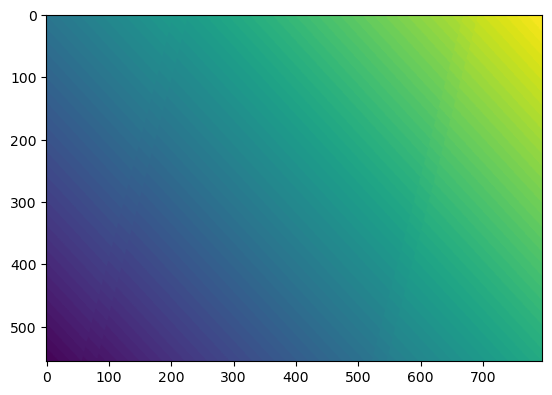

In [112]:
with rasterio.open('dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/LC08_L1TP_116034_20210618_20210628_02_T1_SAA.TIF') as thermal_src:
    s_band = thermal_src.read(1)
plt.imshow(s_band)

IndexError: index 4 is out of bounds for axis 0 with size 4

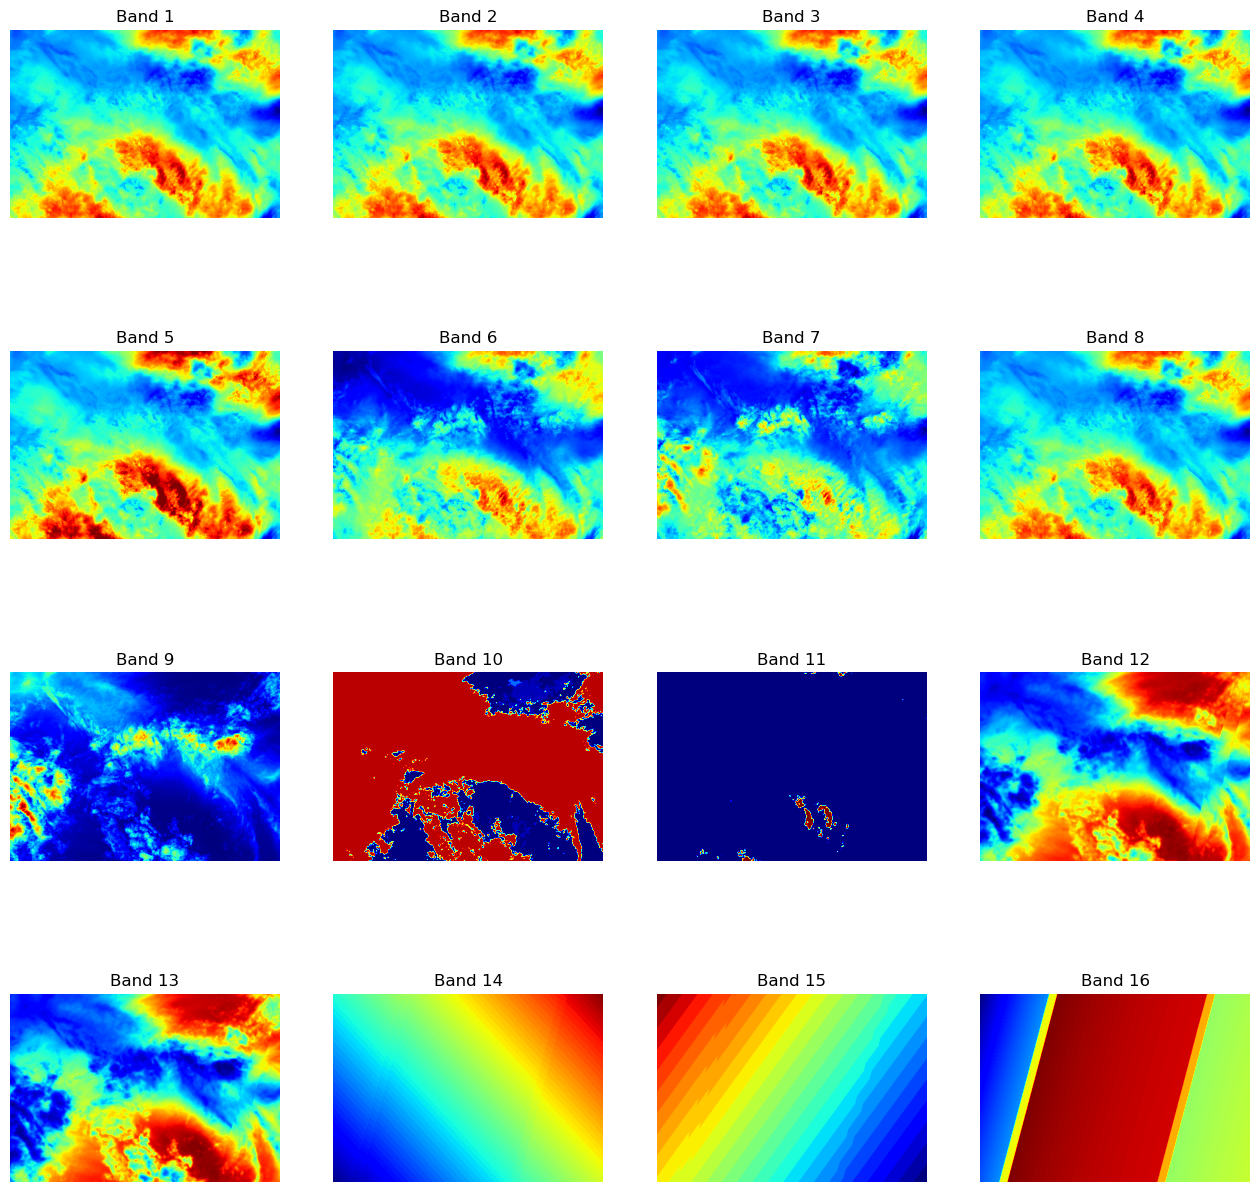

In [113]:
import os
import glob
import subprocess

# 상위 디렉토리 경로 설정
base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
#for directory in subdirectories:
    # 입력 폴더에서 모든 TIF 파일 찾기
directory = subdirectories[0]
tif_files = glob.glob(os.path.join(directory + '/', "*.tif"))

condition_band_path_SAA = tif_files[-4]
condition_band_path_SZA = tif_files[-3]
condition_band_path_VAA = tif_files[-2]
condition_band_path_VZA = tif_files[-1]
# Rasterio를 사용하여 SAA 밴드 열기
with rasterio.open(condition_band_path_SAA) as saa_src:
    saa_band = saa_src.read(1)
# Rasterio를 사용하여 SAA 밴드 열기
with rasterio.open(condition_band_path_SZA) as sza_band:
    sza_band = sza_band.read(1)
# Rasterio를 사용하여 SAA 밴드 열기
with rasterio.open(condition_band_path_VAA) as vaa_band:
    vaa_band = vaa_band.read(1)
# Rasterio를 사용하여 SAA 밴드 열기
with rasterio.open(condition_band_path_VZA) as vza_band:
    vza_band = vza_band.read(1)

# 열온도 밴드와 SAA를 결합하여 서브플롯으로 표시
fig, axs = plt.subplots(4, 4, figsize=(16, 16))  # 3x4 그리드로 서브플롯 생성

tif_files = tif_files[:13]
# 2~3번째 요소 추출
extracted_elements = tif_files[1:3]
pix = tif_files[13:]
# 추출한 요소를 맨 뒤로 배치하고 중복을 피하기 위해 제거
tif_files = [x for x in tif_files if x not in extracted_elements + pix] + extracted_elements + pix

for i, band_path in enumerate(tif_files):
    # 열온도 밴드 열기
    with rasterio.open(band_path) as thermal_src:
        thermal_band = thermal_src.read(1)
    # SZA와 열온도를 결합하여 이미지 생성
    try:
        combined_data = thermal_band# * sza_band
    except:
        combined_data = thermal_band
    # 서브플롯에 이미지 표시
    row = i // 4
    col = i % 4
    axs[row, col].imshow(combined_data, cmap='jet')
    axs[row, col].set_title(f'Band {i + 1}')
    axs[row, col].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle('Combining Thermal Bands with SAA')
plt.show()
    # for input_tif in tif_files:
    #     # 파일 이름만 추출하여 출력 폴더와 결합
    #     input_filename = os.path.basename(input_tif)

    #     if not input_filename.endswith("_geotiff.tif"):
    #         output_geotiff = os.path.join(directory + '/', input_filename.replace(".tif", "_geotiff.tif"))

    #         # gdal_translate 명령어 실행
    #         cmd = ["gdal_translate", "-of", "GTiff", input_tif, output_geotiff]

    #         try:
    #             subprocess.run(cmd, check=True)
    #             print(f"{input_tif}을 GeoTIFF로 성공적으로 변환했습니다.")
    #         except subprocess.CalledProcessError as e:
    #             print(f"{input_tif} 변환 중 오류 발생:", e)

In [49]:
tif_files

['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B1.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B2.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B3.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B4.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B5.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B6.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B7.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B8.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_2021

## MLT파일정보 파헤치기

In [2]:
import os
import glob
import subprocess

# 상위 디렉토리 경로 설정
base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
for directory in subdirectories:
    # 입력 폴더에서 모든 TIF 파일 찾기
    tif_files = glob.glob(os.path.join(directory + '/', "*stac.json"))
    print(tif_files)
    # for input_tif in tif_files:
    #     # 파일 이름만 추출하여 출력 폴더와 결합
    #     input_filename = os.path.basename(input_tif)

    #     if not input_filename.endswith("_geotiff.tif"):
    #         output_geotiff = os.path.join(directory + '/', input_filename.replace(".tif", "_geotiff.tif"))

    #         # gdal_translate 명령어 실행
    #         cmd = ["gdal_translate", "-of", "GTiff", input_tif, output_geotiff]

    #         try:
    #             subprocess.run(cmd, check=True)
    #             print(f"{input_tif}을 GeoTIFF로 성공적으로 변환했습니다.")
    #         except subprocess.CalledProcessError as e:
    #             print(f"{input_tif} 변환 중 오류 발생:", e)

['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_stac.json']
['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210720_20210729_02_T1\\LC08_L1TP_116034_20210720_20210729_02_T1_stac.json']
['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210805_20210811_02_T1\\LC08_L1TP_116034_20210805_20210811_02_T1_stac.json']
['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210906_20210915_02_T1\\LC08_L1TP_116034_20210906_20210915_02_T1_stac.json']
['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20220605_20220610_02_T1\\LC08_L1TP_116034_20220605_20220610_02_T1_stac.json']
['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20220707_20220721_02_T1\\LC08_L1TP_116034_20220707_20220721_02_T1_stac.json']
['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20220824_20220923_02_T1\\LC08_L1TP_116034_20220824_20220923_02_T1_stac.json']
['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20220925_20221004_02_T1\\LC08_L1TP_116034_20220925_20221004_02_T1_stac.json']


In [ ]:
import pandas as pd
from pandas import json_normalize
# JSON 파일 읽기
json_data = "dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_stac.json"

# JSON 데이터를 DataFrame으로 변환
df = json_normalize(json_data)

# DataFrame 출력
print(df)

## tif 파헤치기

In [ ]:
# import os
# import glob
# import subprocess

# # 상위 디렉토리 경로 설정
# base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# # 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
# subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# # 각 서브 디렉토리를 반복하면서 XML 파일 읽기
# for directory in subdirectories:
#     # 입력 폴더에서 모든 TIF 파일 찾기
#     tif_files = glob.glob(os.path.join(directory + '/', "*.tif"))

#     for input_tif in tif_files:
#         # 파일 이름만 추출하여 출력 폴더와 결합
#         input_filename = os.path.basename(input_tif)

#         if not input_filename.endswith("_geotiff.tif"):
#             output_geotiff = os.path.join(directory + '/', input_filename.replace(".tif", "_geotiff.tif"))

#             # gdal_translate 명령어 실행
#             cmd = ["gdal_translate", "-of", "GTiff", input_tif, output_geotiff]

#             try:
#                 subprocess.run(cmd, check=True)
#                 print(f"{input_tif}을 GeoTIFF로 성공적으로 변환했습니다.")
#             except subprocess.CalledProcessError as e:
#                 print(f"{input_tif} 변환 중 오류 발생:", e)